## Initial attempt at setting up a simple image classification model using embeddings and KNN

- initially based on : https://github.com/rom1504/image_embeddings

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

%matplotlib inline

import tensorflow as tf

#import cv2

#import os

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
sns.set_style("darkgrid") # darkgrid
sns.set_context("notebook") # paper, notebook, talk, and poster

## Load the data

In [3]:
# first load the training labels
train_labels = pd.read_csv("../data/train.csv")
train_labels = train_labels[0:2000]
train_labels

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18
...,...,...
1995,10e05a6c-bba2-11e8-b2b9-ac1f6b6435d0,7 0
1996,10e0a0f0-bbaa-11e8-b2ba-ac1f6b6435d0,0
1997,10e4030c-bba6-11e8-b2ba-ac1f6b6435d0,25 0
1998,10e9707c-bbaa-11e8-b2ba-ac1f6b6435d0,7 0


#### Now load the images; combine the 4 colors and put them with the labels into TFRecord format

Advantages of the TFRecord format (from https://keras.io/examples/keras_recipes/creating_tfrecords/): 
- More efficient storage: the TFRecord data can take up less space than the original data; it can also be partitioned into multiple files.
- Fast I/O: the TFRecord format can be read with parallel I/O operations, which is useful for TPUs or multiple hosts.
- Self-contained files: the TFRecord data can be read from a single source—for example, the COCO2017 dataset originally stores data in two folders ("images" and "annotations").
- An important use case of the TFRecord data format is training on TPUs. First, TPUs are fast enough to benefit from optimized I/O operations. In addition, TPUs require data to be stored remotely (e.g. on Google Cloud Storage) and using the TFRecord format makes it easier to load the data without batch-downloading.

In [4]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_png(value).numpy()])
    )

def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def create_example(image, path, target_id):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "target_id": bytes_feature(target_id)
        #"area": float_feature(example["area"]),
        #"bbox": float_feature_list(example["bbox"]),
        #"category_id": int64_feature(example["category_id"]),
        #"id": int64_feature(example["id"]),
        #"image_id": int64_feature(example["image_id"]),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))
    

def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        # "area": tf.io.FixedLenFeature([], tf.float32),
        # "bbox": tf.io.VarLenFeature(tf.float32),
        # "category_id": tf.io.FixedLenFeature([], tf.int64),
        # "id": tf.io.FixedLenFeature([], tf.int64),
        "target_id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)
    #example["bbox"] = tf.sparse.to_dense(example["bbox"])
    return example

def read_file(src_dir_fname):
  image1 = tf.io.decode_png(tf.io.read_file(src_dir_fname))#, dtype=tf.uint8)
  return image1

In [5]:
# loop through all the files, combine the 4 colors into an array and save to tfrecord
base_path = '../data/train/'
str_list = ['_red.png', '_blue.png', '_green.png']# ,'_yellow.png']

# iterate over images in directory
file_path = base_path+'data.tfrec'
with tf.io.TFRecordWriter(file_path) as tfrecord_writer:
  for fname, target in zip(train_labels.Id, train_labels.Target):
    # try read image file
    try:
      raw_file = tf.concat([read_file(base_path+fname+end_str) for end_str in str_list], axis=2)

    except FileNotFoundError:
      print("Couldn't read file  {}".format(base_path+fname+end_str))
      continue
    # create an example with the image and label
    example = create_example(raw_file, base_path+fname+'.png', target)
    # write example
    tfrecord_writer.write(example.SerializeToString())


#   !!! TO DO: separate into shards so files don't get so big (?)
# def image_files_to_tfrecords(list_ds, output_folder, num_shard):
#     start = time.time()
#     for shard_id in range(0, num_shard):
#         shard_list = list_ds.shard(num_shards=num_shard, index=shard_id)
#         read_image_file_write_tfrecord(shard_list, output_folder + "/part-" + "{:03d}".format(shard_id) + ".tfrecord")
#         print("Shard " + str(shard_id) + " saved after " + str(int(time.time() - start)) + "s")


2022-06-29 09:06:30.779411: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-29 09:06:30.779531: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



path: b'../data/train/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0.png'
target_id: b'5'
Image shape: (512, 512, 3)


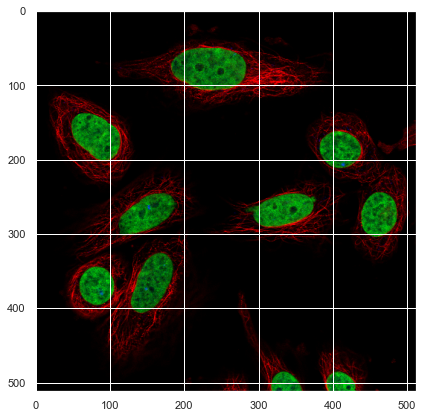

path: b'../data/train/000c99ba-bba4-11e8-b2b9-ac1f6b6435d0.png'
target_id: b'1'
Image shape: (512, 512, 3)


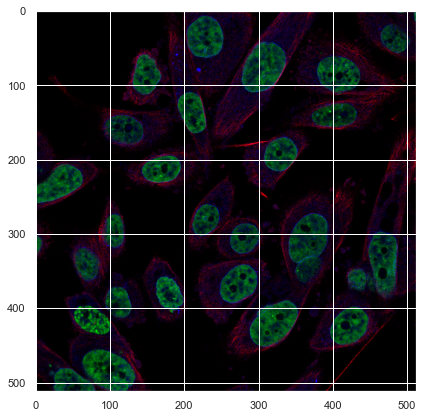

path: b'../data/train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0.png'
target_id: b'7 1 2 0'
Image shape: (512, 512, 3)


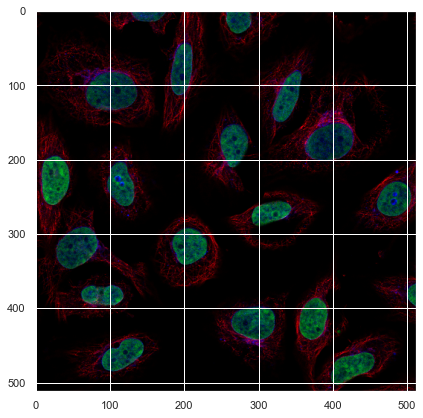

In [ ]:
# try opening an image
raw_dataset = tf.data.TFRecordDataset(f"{base_path}data.tfrec")
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.shuffle(5).take(3):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()

In [23]:
!pip install efficientnet
!pip install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 7.1 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 7.0 MB/s eta 0:00:007.3 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.8 MB/s eta 0:00:007.4 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 kB 4.0 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 7.0 MB/s eta 0:00:00m eta 0:00:010:01:01


In [7]:
!rm -rf ../data/embeddings_train
!mkdir ../data/embeddings_train

In [8]:
import pyarrow.parquet as pq
import pyarrow as pa

def save_embeddings_ds_to_parquet(embeddings, dataset, path):
    embeddings = pa.array(embeddings.tolist(), type=pa.list_(pa.float32()))
    image_names = pa.array(dataset.map(lambda image_raw, image_name: image_name).as_numpy_iterator())
    table = pa.Table.from_arrays([image_names, embeddings], ["image_name", "embedding"])
    pq.write_table(table, path)
    
def images_to_embeddings(model, dataset, batch_size):
    return model.predict(dataset.batch(batch_size).map(lambda image_raw, image_name: image_raw), verbose=1)

def preprocess_image(d):
    target_id = d['target_id']
    raw = d['image']
    #image = tf.image.decode_png(raw)
    image = tf.image.convert_image_dtype(raw, tf.float32)

    return image, target_id
    
def tfrecords_to_write_embeddings(tfrecords_folder, output_folder, model, batch_size):
    #tfrecords = [f.numpy().decode("utf-8") for f in \
    #             tf.data.Dataset.list_files(tfrecords_folder + "/*.tfrec", shuffle=False)]
    #start = time.time()
    #for shard_id, tfrecord in enumerate(tfrecords):
    #shard = read_tfrecord(tfrecord)
    raw_dataset = tf.data.TFRecordDataset(f"{base_path}data.tfrec")
    parsed_dataset = raw_dataset \
        .map(parse_tfrecord_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .apply(tf.data.experimental.ignore_errors())

    embeddings = images_to_embeddings(model, parsed_dataset, batch_size)
    print("")
    #print("Shard " + str(shard_id) + " done after " + str(int(time.time() - start)) + "s")
    save_embeddings_ds_to_parquet(embeddings, parsed_dataset,
                                    output_folder + "/embedding_test.parquet")
    #print("Shard " + str(shard_id) + " saved after " + str(int(time.time() - start)) + "s")

In [10]:
from efficientnet.tfkeras import EfficientNetB0


def run_inference(tfrecords_folder, output_folder, batch_size=1000):
    model = EfficientNetB0(weights='imagenet', include_top=False, pooling="avg")
    tfrecords_to_write_embeddings(tfrecords_folder, output_folder, model, batch_size)



In [12]:
run_inference("../data/train", "../data/embeddings_train", 10)

2022-06-29 11:07:34.157343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


ResourceExhaustedError: Graph execution error:

Detected at node 'efficientnet-b0/block2a_expand_conv/Conv2D' defined at (most recent call last):
    File "/Users/ryan/.pyenv/versions/3.9.8/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/ryan/.pyenv/versions/3.9.8/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/ryan/.pyenv/versions/3.9.8/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/Users/ryan/.pyenv/versions/3.9.8/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/Users/ryan/.pyenv/versions/3.9.8/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/vn/y7lprnhs06j1j5w4cj9t64080000gn/T/ipykernel_33041/4052326481.py", line 1, in <cell line: 1>
      run_inference("../data/train", "../data/embeddings_train", 200)
    File "/var/folders/vn/y7lprnhs06j1j5w4cj9t64080000gn/T/ipykernel_33041/4252119445.py", line 6, in run_inference
      tfrecords_to_write_embeddings(tfrecords_folder, output_folder, model, batch_size)
    File "/var/folders/vn/y7lprnhs06j1j5w4cj9t64080000gn/T/ipykernel_33041/3698620064.py", line 33, in tfrecords_to_write_embeddings
      embeddings = images_to_embeddings(model, parsed_dataset, batch_size)
    File "/var/folders/vn/y7lprnhs06j1j5w4cj9t64080000gn/T/ipykernel_33041/3698620064.py", line 11, in images_to_embeddings
      return model.predict(dataset.batch(batch_size).map(lambda image_raw, image_name: image_raw), verbose=1)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1791, in predict_step
      return self(x, training=False)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/Users/ryan/neue_fische/human-protein-atlas-image-classification/.venv/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'efficientnet-b0/block2a_expand_conv/Conv2D'
OOM when allocating tensor with shape[200,256,256,96] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator Simple allocator
	 [[{{node efficientnet-b0/block2a_expand_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_34941]

In [11]:
emb = pq.read_table("../data/embeddings_train").to_pandas()

In [12]:
emb

,image_name,embedding
0,b'16 0',"[-0.16242778, -0.105916545, -0.14529389, -0.03..."
1,b'7 1 2 0',"[-0.12603691, -0.15263456, -0.103106946, -0.12..."
2,b'5',"[-0.18897206, -0.19018914, -0.032292187, -0.13..."
3,b'1',"[-0.1210375, -0.1288869, -0.14070033, -0.12894..."
4,b'18',"[-0.114861585, -0.1510871, -0.1432612, -0.1111..."
